In [1]:
%load_ext autoreload
%autoreload 2

# Libraries

In [2]:
import os
import sys

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

In [3]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

from src.bnn.dataset import TabularDataset
from src.bnn.model import BNN
from src.utils import get_device, get_logger

# Playground

In [50]:
import h5py

with h5py.File("../data/test-public-small.h5", 'r') as f_in:
    print(f_in.keys())
    print(f_in['labels'][3:10])
    print(f_in['fjet_pt'][3:10])

<KeysViewHDF5 ['fjet_C2', 'fjet_D2', 'fjet_ECF1', 'fjet_ECF2', 'fjet_ECF3', 'fjet_L2', 'fjet_L3', 'fjet_Qw', 'fjet_Split12', 'fjet_Split23', 'fjet_Tau1_wta', 'fjet_Tau2_wta', 'fjet_Tau3_wta', 'fjet_Tau4_wta', 'fjet_ThrustMaj', 'fjet_clus_E', 'fjet_clus_eta', 'fjet_clus_phi', 'fjet_clus_pt', 'fjet_eta', 'fjet_m', 'fjet_phi', 'fjet_pt', 'labels', 'weights']>
[1 0 0 0 1 0 1]
[ 726583.25 1437656.6  1100925.2   436800.47 1565111.9  1292001.1
 1563887.4 ]


# Utilities

In [5]:
def load_model(path_to_checkpoint, input_dim, device):
    model = BNN(input_dim)
    checkpoint = torch.load(path_to_checkpoint, map_location=device)
    state = checkpoint["model_state"] if "model_state" in checkpoint else checkpoint
    model.load_state_dict(state)
    model.to(device)
    model.eval()
    return model

In [ ]:
def mc_inference(model, X, n_samples=10):
    model.train()
    for m in model.modules():
        if isinstance(m, nn.BatchNorm1d):
            m.eval()
    with torch.no_grad():
        preds = torch.stack([model(X) for _ in range(n_samples)])
        preds = torch.sigmoid(preds)
    return preds.mean(0), preds.var(0)

In [7]:
def infer_with_bnn(dataset, model, device, n_samples=10, batch_size=10_000):
    logger = get_logger("inference")
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    means, vars_, targets, pts = [], [], [], []
    for idx, batch in enumerate(loader):
        logger.info(f"Processing batch {idx}")
        X, y, pt = batch[0], batch[1], batch[2]
        X = X.to(device).view(X.size(0), -1)
        mean, var = mc_inference(model, X, n_samples)
        means.append(mean.detach().cpu())
        vars_.append(var.detach().cpu())
        targets.append(y.view(-1).detach().cpu())
        pt = pt.tolist()
        pts.extend(pt)

    mean_all = torch.cat(means).detach().numpy()
    var_all = torch.cat(vars_).detach().numpy()
    target_all = torch.cat(targets).detach().numpy()

    df = pd.DataFrame({
        "mean": mean_all.flatten(),
        "var": var_all.flatten(),
        "target": target_all.flatten(),
        "jet_pt": pts, 
    })
    return df


# Constants

In [8]:
path_to_checkpoint = "../checkpoints/bnn/best_model.pt"
path_to_dataset    = "../data/test-preprocessed.h5"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

dataset = TabularDataset(
    path_to_dataset,
    max_jets=1_000_000,
    use_jet_pt=True,
    use_train_weights=False,
)
x0, y0, *_ = dataset[0]
input_dim = x0.numel()

model = load_model(path_to_checkpoint, input_dim, device)

# Visualizations

In [9]:
df = infer_with_bnn(dataset, model, device, n_samples=10)

2025-11-04 15:02:47 - inference - INFO - Processing batch 0
2025-11-04 15:02:48 - inference - INFO - Processing batch 1
2025-11-04 15:02:49 - inference - INFO - Processing batch 2
2025-11-04 15:02:51 - inference - INFO - Processing batch 3
2025-11-04 15:02:52 - inference - INFO - Processing batch 4
2025-11-04 15:02:53 - inference - INFO - Processing batch 5
2025-11-04 15:02:54 - inference - INFO - Processing batch 6
2025-11-04 15:02:56 - inference - INFO - Processing batch 7
2025-11-04 15:02:57 - inference - INFO - Processing batch 8
2025-11-04 15:02:58 - inference - INFO - Processing batch 9
2025-11-04 15:03:00 - inference - INFO - Processing batch 10
2025-11-04 15:03:01 - inference - INFO - Processing batch 11
2025-11-04 15:03:02 - inference - INFO - Processing batch 12
2025-11-04 15:03:03 - inference - INFO - Processing batch 13
2025-11-04 15:03:05 - inference - INFO - Processing batch 14
2025-11-04 15:03:06 - inference - INFO - Processing batch 15
2025-11-04 15:03:07 - inference - 

In [10]:
def plot_pt_distribution(df):
    mask_sig = df['target'] == 1
    mask_bkg = df['target'] == 0

    plt.hist(df.loc[mask_bkg, 'jet_pt'], 
             bins=80, density=True, alpha=0.7, 
             color='steelblue', label='Background', 
             edgecolor='black', linewidth=0.3)
    
    plt.hist(df.loc[mask_sig, 'jet_pt'], 
             bins=80, density=True, alpha=0.7, 
             color='crimson', label='Signal', 
             edgecolor='black', linewidth=0.3)
    
    plt.xlabel('Jet $p_T$ [GeV]', fontsize=12)
    plt.ylabel('Density', fontsize=12)
    plt.title('Jet $p_T$ Distribution', fontsize=14)
    plt.legend()

    plt.show()

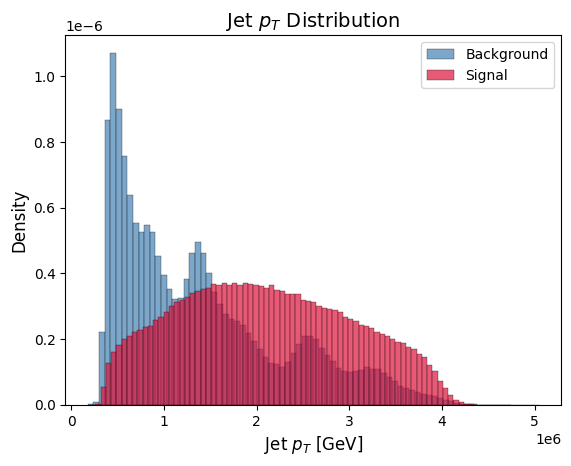

In [11]:
plot_pt_distribution(df)

In [83]:
def plot_prediction(t=10, jet_idx=0):
    """
    Plot MC-sampled BNN predictions for a single jet.

    Parameters
    ----------
    t : int
        Number of MC dropout forward passes.
    jet_idx   : int
        Index of the jet in the dataset.
    """
    # ---- get one jet -----------------------------------------
    x, y, pt = dataset[jet_idx][:3]
    x = x.unsqueeze(0).to(device)                     # [1, input_dim]

    # ---- MC dropout (same as mc_inference) -------------------
    model.train()                                     # enable dropout
    for m in model.modules():
        if isinstance(m, nn.BatchNorm1d):
            m.eval()                                  # keep BN fixed

    with torch.no_grad():
        preds = torch.stack([model(x) for _ in range(t)])
        preds = torch.sigmoid(preds)                  # [t, 1]

    mean_pred = preds.mean(0).item()
    var_pred  = preds.var(0).item()
    samples   = preds.squeeze(1).cpu().numpy()        # [t]

    # ---- plot ------------------------------------------------
    plt.hist(samples, bins=max(6, t//2), density=True,
             color='steelblue', alpha=0.75, label='MC samples')

    sigma = var_pred**0.5
    #plt.axvline(mean_pred, color='black', lw=2,
    #            label=f'mean = {mean_pred:.3f}')
    plt.axvline(mean_pred + sigma, color='gray', ls='--', alpha=0.8)
    plt.axvline(mean_pred - sigma, color='gray', ls='--', alpha=0.8)
    plt.axvline( color='gray', ls='--', alpha=0.8,
                label=f'±1σ = [{mean_pred-sigma:.3f}, {mean_pred+sigma:.3f}]')

    true = int(y.item())
    plt.axvline(true, color='crimson', lw=2,
                label=f'true = {true}')
    # TODO: Add mean as a line
    plt.xlim(mean_pred - sigma*4, mean_pred + sigma*4)
    plt.xlabel('Predicted probability')
    plt.ylabel('Density')
    plt.title(f'Jet {jet_idx}  (p_T = {pt:.0f} GeV)')
    plt.legend(fontsize=10)
    plt.grid(True, which='both', alpha=0.3, linestyle=':')
    plt.show()

    # ---- summary ---------------------------------------------
    print(f"jet {jet_idx:>6} | p_T = {pt:>5.0f} GeV | true = {true} | "
          f"mean = {mean_pred:.3f} ± {sigma:.3f}  (var = {var_pred:.5f})")

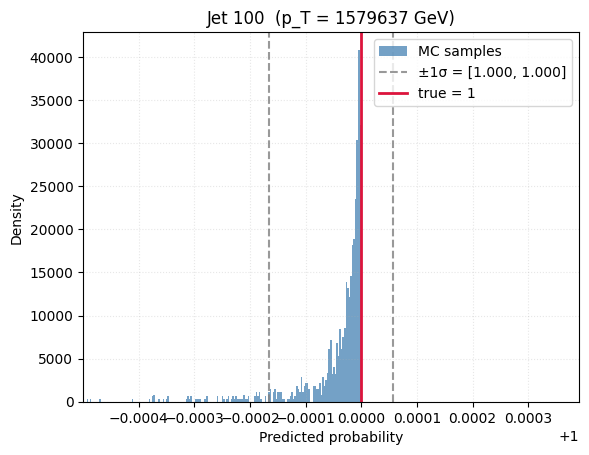

jet    100 | p_T = 1579637 GeV | true = 1 | mean = 1.000 ± 0.000  (var = 0.00000)


In [ ]:
plot_prediction(jet_idx=100, t=1000)

In [85]:
def plot_mean_vs_pt(df, pt_col='jet_pt', var_col='var', nbins=40):
    # Common bins for both classes
    pt_min, pt_max = df[pt_col].min(), df[pt_col].max()
    bins = np.linspace(pt_min, pt_max, nbins + 1)
    bin_centers = (bins[:-1] + bins[1:]) / 2

    def stats_per_bin(mask):
        # Assign each jet to a bin
        bin_idx = np.digitize(df.loc[mask, pt_col], bins) - 1
        # Keep only jets inside the defined range
        valid = (bin_idx >= 0) & (bin_idx < nbins)
        bin_idx = bin_idx[valid]

        var_vals = df.loc[mask, var_col].values[valid]

        # Group by bin index
        means   = []
        stderrs = []
        counts  = []
        for i in range(nbins):
            in_bin = (bin_idx == i)
            if in_bin.sum() > 0:
                m = np.mean(var_vals[in_bin])
                means.append(m)
                stderrs.append(np.std(var_vals[in_bin]) / np.sqrt(in_bin.sum()))  # SEM
                counts.append(in_bin.sum())
            else:
                means.append(np.nan)
                stderrs.append(np.nan)
                counts.append(0)
        return np.array(means), np.array(stderrs), np.array(counts)

    # Compute for each class
    mean_bkg, err_bkg, n_bkg = stats_per_bin(df['target'] == 0)
    mean_sig, err_sig, n_sig = stats_per_bin(df['target'] == 1)

    #plt.figure(figsize=(10, 6))
    plt.errorbar(bin_centers, mean_bkg, yerr=err_bkg,
                 fmt='o', color='steelblue', label='Background',
                 capsize=3, markersize=4, alpha=0.9)
    plt.errorbar(bin_centers, mean_sig, yerr=err_sig,
                 fmt='s', color='crimson', label='Signal',
                 capsize=3, markersize=4, alpha=0.9)

    plt.xlabel('Jet $p_T$ [GeV]', fontsize=12)
    plt.ylabel(f'Mean of `{var_col}`', fontsize=12)
    plt.title(f'Mean of `{var_col}` vs. Jet $p_T$', fontsize=14)
    plt.legend()
    plt.grid(True, which='both', alpha=0.3, linestyle=':')
    plt.show()

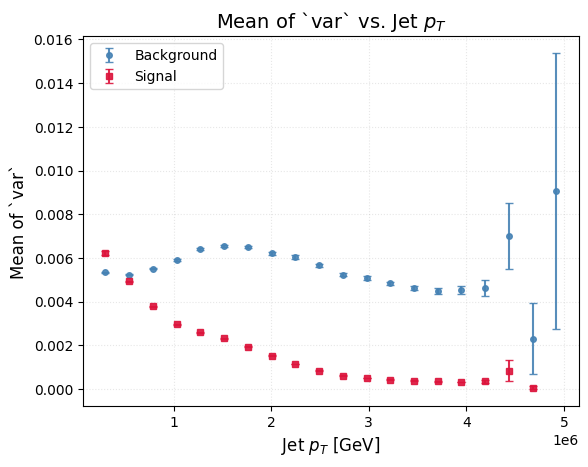

In [86]:
plot_mean_vs_pt(df, nbins=20)

In [90]:
df

,mean,var,target,jet_pt
0,0.994963,1.049912e-05,0.0,1.275630e+06
1,0.892517,3.556976e-04,0.0,1.270416e+06
2,0.999735,1.760352e-08,0.0,8.229378e+05
3,0.963989,5.846066e-04,0.0,2.609111e+06
4,0.372249,1.983286e-03,1.0,1.249122e+06
...,...,...,...,...
999995,0.981941,8.595985e-05,1.0,2.021210e+06
999996,0.994183,4.043197e-06,0.0,1.190182e+06
999997,0.940297,8.270649e-04,0.0,2.295991e+06
999998,0.431118,3.989167e-03,1.0,7.922265e+05


In [88]:
def entropy(p):
    """Shannon entropy for binary probability p (in [0,1])"""
    p = np.clip(p, 1e-12, 1 - 1e-12)  # avoid log(0)
    return -(p * np.log2(p) + (1 - p) * np.log2(1 - p))

def plot_entropy_vs_pt(df, pt_col='jet_pt', mean_col='mean', nbins=40, min_entries=10):
    """
    Plot mean Shannon entropy (uncertainty) vs. jet p_T.
    
    Parameters
    ----------
    df : pd.DataFrame
        Must contain: 'mean' (from MC inference), 'jet_pt', 'target'
    pt_col : str
        Name of p_T column
    mean_col : str
        Name of mean prediction column
    nbins : int
        Number of p_T bins
    min_entries : int
        Minimum jets per bin to show point
    """
    # Compute entropy per jet
    df = df.copy()
    df['entropy'] = entropy(df[mean_col])

    # Binning
    pt_min, pt_max = df[pt_col].min(), df[pt_col].max()
    bins = np.linspace(pt_min, pt_max, nbins + 1)
    bin_centers = (bins[:-1] + bins[1:]) / 2

    def mean_entropy_per_bin(mask):
        idx = np.digitize(df.loc[mask, pt_col], bins) - 1
        valid = (idx >= 0) & (idx < nbins)
        idx = idx[valid]
        ent_vals = df.loc[mask, 'entropy'].values[valid]

        means = []
        counts = []
        for i in range(nbins):
            in_bin = (idx == i)
            n = in_bin.sum()
            if n >= min_entries:
                means.append(np.mean(ent_vals[in_bin]))
                counts.append(n)
            else:
                means.append(np.nan)
                counts.append(0)
        return np.array(means), np.array(counts)

    # Compute for each class
    ent_bkg, n_bkg = mean_entropy_per_bin(df['target'] == 0)
    ent_sig, n_sig = mean_entropy_per_bin(df['target'] == 1)

    # Plot
    plt.plot(bin_centers, ent_bkg, 'o', color='steelblue', markersize=5, label='Background')
    plt.plot(bin_centers, ent_sig, 's', color='crimson',   markersize=5, label='Signal')

    plt.xlabel('Jet $p_T$ [GeV]', fontsize=12)
    plt.ylabel('Mean Shannon Entropy (bits)', fontsize=12)
    plt.title('Shannon Entropy vs. Jet $p_T$', fontsize=14)
    plt.legend()
    plt.grid(True, which='both', alpha=0.3, linestyle=':')
    plt.show()

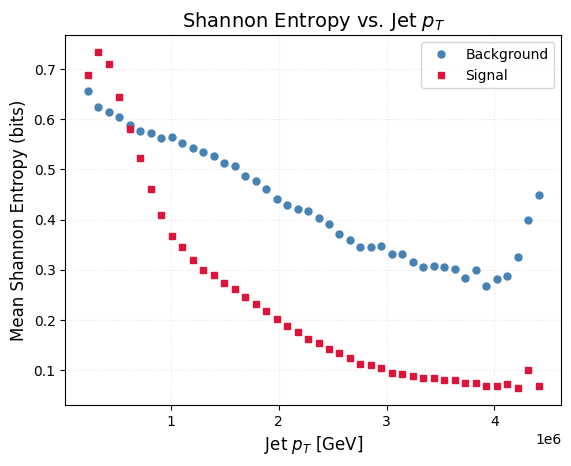

In [ ]:
plot_entropy_vs_pt(df, min_entries=5, nbins=50)

In [42]:
import numpy as np
import matplotlib.pyplot as plt

def plot_background_rejection_vs_pt(
    df, 
    pt_col='jet_pt', 
    mean_col='mean', 
    nbins=40, 
    min_entries=10, 
    threshold=0.5
):
    """
    Plot background rejection = 1/FPR vs. jet p_T (binned).
    FPR = FP / (FP + TN) correctly computed per bin.
    """
    # Binning
    pt_min, pt_max = df[pt_col].min(), df[pt_col].max()
    bins = np.linspace(pt_min, pt_max, nbins + 1)
    bin_centers = (bins[:-1] + bins[1:]) / 2
    bin_width = bin_centers[1] - bin_centers[0] if len(bin_centers) > 1 else 1.0

    # Background only
    bkg = df[df['target'] == 0]
    idx = np.digitize(bkg[pt_col], bins) - 1
    valid = (idx >= 0) & (idx < nbins)
    idx = idx[valid]
    pred = bkg[mean_col].values[valid]

    rej = []
    for i in range(nbins):
        in_bin = (idx == i)
        n = in_bin.sum()
        if n >= min_entries:
            pred_bin = pred[in_bin]
            fp = np.sum(pred_bin > threshold)
            tn = np.sum(pred_bin <= threshold)
            fpr = fp / (fp + tn) if (fp + tn) > 0 else 1.0
            fpr = max(fpr, 1e-6)
            rej.append(1.0 / fpr)
        else:
            rej.append(np.nan)

    # Plot: one horizontal line per bin
    #plt.figure(figsize=(10, 6))
    for x, r in zip(bin_centers, rej):
        if not np.isnan(r):
            plt.hlines(r, x - 0.4*bin_width, x + 0.4*bin_width,
                       color='steelblue', linewidth=4)
    plt.xlabel('Jet $p_T$ [GeV]', fontsize=12)
    plt.ylabel('Background Rejection (1/FPR)', fontsize=12)
    plt.title(f'1/FPR vs. Jet $p_T$ (threshold = {threshold})', fontsize=14)
    plt.grid(True, which='both', alpha=0.3, linestyle=':')
    plt.show()

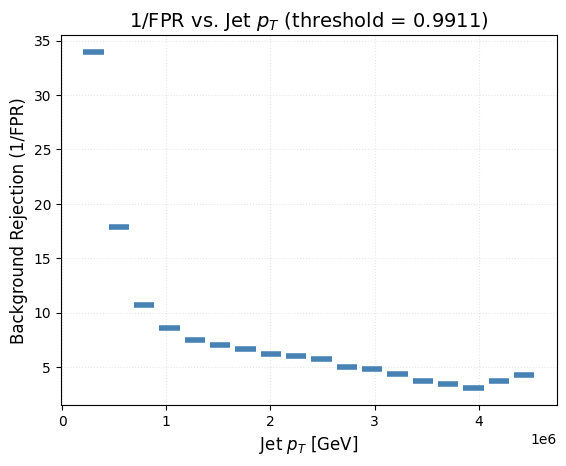

In [43]:
plot_background_rejection_vs_pt(df, nbins=20, threshold=0.9911) # epsilon 0.8

In [96]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def mutual_information_per_pt_bin(
    df,
    pt_col='jet_pt',
    mean_col='mean',      # float in [0,1]
    target_col='target',  # 0 or 1
    nbins=40,
    min_entries=50
):
    """
    Compute and plot I(mean; target | p_T) in each p_T bin.
    
    Returns
    -------
    dict with bin_centers, mi, n_signal, n_background
    """
    df = df.copy()
    
    # Clip predictions to avoid log(0)
    df['p'] = np.clip(df[mean_col], 1e-12, 1 - 1e-12)
    
    # Shannon entropy of each prediction: H(y | p_i)
    df['entropy'] = -(df['p'] * np.log2(df['p']) + (1 - df['p']) * np.log2(1 - df['p']))

    # Binning
    pt_min, pt_max = df[pt_col].min(), df[pt_col].max()
    bins = np.linspace(pt_min, pt_max, nbins + 1)
    bin_centers = (bins[:-1] + bins[1:]) / 2
    df['bin_idx'] = np.digitize(df[pt_col], bins) - 1
    df['bin_idx'] = df['bin_idx'].clip(0, nbins - 1)

    mi_per_bin = np.full(nbins, np.nan)
    n_sig = np.zeros(nbins, dtype=int)
    n_bkg = np.zeros(nbins, dtype=int)

    for i in range(nbins):
        mask = df['bin_idx'] == i
        if mask.sum() < min_entries:
            continue

        sub = df[mask]
        n_s = (sub[target_col] == 1).sum()
        n_b = (sub[target_col] == 0).sum()
        n_tot = n_s + n_b

        if n_s == 0 or n_b == 0:
            continue  # H(y|p_T) undefined or MI=0

        n_sig[i] = n_s
        n_bkg[i] = n_b

        # H(target | p_T) = entropy of label proportion
        p_sig = n_s / n_tot
        H_y_pt = - (p_sig * np.log2(p_sig) + (1 - p_sig) * np.log2(1 - p_sig))

        # H(target | mean, p_T) ≈ mean entropy of predictions in bin
        H_y_given_mean_pt = sub['entropy'].mean()

        # Mutual Information
        mi = H_y_pt - H_y_given_mean_pt
        mi_per_bin[i] = max(mi, 0.0)  # clip small negative due to sampling

    # === Plot ===
    #plt.figure(figsize=(10, 5.5))
    valid = ~np.isnan(mi_per_bin)
    plt.plot(bin_centers[valid], mi_per_bin[valid],
             'D-', color='darkorange', markersize=7, linewidth=2,
             label=r'$I(\hat{p}; y \mid p_T)$')

    plt.xlabel(r'Jet $p_T$ [GeV]', fontsize=13)
    plt.ylabel('Mutual Information (bits)', fontsize=13)
    plt.title('Mutual Infomration vs. Jet $p_T$ Bin', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True, alpha=0.3, linestyle=':')
    plt.tight_layout()
    plt.show()

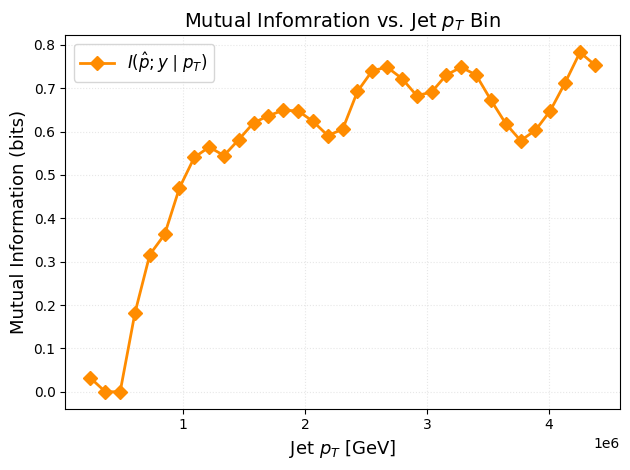

In [97]:
mutual_information_per_pt_bin(df) #In this $ p_T $ region, how much does the predicted probability reduce my uncertainty about the true label

# old

In [ ]:
# --------------------------------------------------------------
# 1. Binning + metric calculation (entropy added)
# --------------------------------------------------------------
import numpy as np
import pandas as pd
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, roc_curve
)

def binned_metric_by_logpt(
    df: pd.DataFrame,
    pt_col: str = "mean_pt_GeV",
    pred_col: str = "mean",          # BNN probability
    true_col: str = "target",
    metric: str = "tpr",             # <-- now also "entropy"
    bins: int | list = 10,
    thr: float = 0.5,
    pt_range: tuple[float, float] | None = None,
) -> pd.DataFrame:
    """
    Bin jets by log(pT) (internally) and return a table with linear pT.
    Supported metrics: accuracy, precision, recall, tpr, fpr, inv_fpr, **entropy**
    """
    df = df.copy()
    df["pred_label"] = (df[pred_col] >= thr).astype(int)

    # ---- optional pT window ------------------------------------------------
    if pt_range is not None:
        low, high = pt_range
        df = df[(df[pt_col] >= low) & (df[pt_col] <= high)]

    df["log_pt"] = np.log10(df[pt_col])

    # ---- bin edges (log-space) --------------------------------------------
    if isinstance(bins, int):
        log_min, log_max = df["log_pt"].min(), df["log_pt"].max()
        edges = np.linspace(log_min, log_max, bins + 1)
    else:
        edges = np.sort(bins)

    df["bin"] = np.digitize(df["log_pt"], edges)

    # ------------------------------------------------------------------ #
    # Helper: classification metrics
    # ------------------------------------------------------------------ #
    def _class_metric(y_true, y_pred):
        if metric == "accuracy":
            return accuracy_score(y_true, y_pred)
        if metric == "precision":
            return precision_score(y_true, y_pred, zero_division=0)
        if metric == "recall":
            return recall_score(y_true, y_pred, zero_division=0)

        fpr, tpr, thr_arr = roc_curve(y_true, df.loc[y_true.index, pred_col])
        idx = np.argmin(np.abs(thr_arr - thr))
        if metric == "tpr":
            return tpr[idx]
        if metric == "fpr":
            return fpr[idx]
        if metric == "inv_fpr":
            f = fpr[idx]
            return 1.0 / f if f > 0 else np.nan
        raise ValueError(f"Unknown classification metric: {metric}")

    # ------------------------------------------------------------------ #
    # Helper: Shannon entropy of a Bernoulli (in bits)
    # ------------------------------------------------------------------ #
    def _entropy(probs: np.ndarray) -> float:
        p = np.clip(probs, 1e-12, 1 - 1e-12)               # avoid log(0)
        return - (p * np.log2(p) + (1 - p) * np.log2(1 - p)).mean()

    # ------------------------------------------------------------------ #
    # Per-bin loop
    # ------------------------------------------------------------------ #
    results = []
    for i in range(len(edges) - 1):
        low_log, high_log = edges[i], edges[i + 1]
        mask = df["bin"] == i + 1
        sub = df[mask]

        low_pt  = 10 ** low_log
        high_pt = 10 ** high_log
        mid_pt  = np.sqrt(low_pt * high_pt)                # geometric centre

        if len(sub) == 0:
            val = np.nan
        else:
            if metric == "entropy":
                val = _entropy(sub[pred_col].values)
            else:
                val = _class_metric(sub[true_col], sub["pred_label"])

        results.append({
            "pt_low":   low_pt,
            "pt_high":  high_pt,
            "pt_mid":   mid_pt,
            "n_jets":   len(sub),
            metric:     val,
        })

    return pd.DataFrame(results)


# --------------------------------------------------------------
# 2. Pure-matplotlib plot (works for entropy too)
# --------------------------------------------------------------
import matplotlib.pyplot as plt

def plot_binned_metric(
    binned_df: pd.DataFrame,
    metric: str = "tpr",
    title: str | None = None,
    ax: plt.Axes | None = None,
) -> plt.Figure:
    if ax is None:
        fig, ax = plt.subplots(figsize=(7, 4.5))
    else:
        fig = ax.figure

    df = binned_df.dropna(subset=[metric]).copy()
    if df.empty:
        ax.text(0.5, 0.5, "No data", ha="center", va="center",
                transform=ax.transAxes, fontsize=14, color="red")
        return fig

    ax.errorbar(
        df["pt_mid"],
        df[metric],
        xerr=(df["pt_mid"] - df["pt_low"], df["pt_high"] - df["pt_mid"]),
        fmt="o-",
        capsize=4,
        label=metric.upper(),
    )

    ax.set_xlabel(r"Mean constituent $p_T$ (GeV)")
    ax.set_ylabel(metric.upper())
    ax.set_xscale("linear")
    if title:
        ax.set_title(title)
    else:
        ax.set_title(f"{metric.upper()} vs. mean constituent $p_T$")

    ax.grid(True, ls=":", alpha=0.6)
    ax.legend(loc="best")
    return fig

          pt_low        pt_high         pt_mid  n_jets   entropy
0    4043.694824    7455.803711    5490.810059     532  0.696621
1    7455.803711   13747.089844   10124.010742    1771  0.557286
2   13747.089844   25347.017578   18666.753906    2434  0.404379
3   25347.017578   46735.074219   34417.941406    2972  0.287214
4   46735.074219   86170.578125   63460.132812    1648  0.240066
5   86170.578125  158882.140625  117008.398438     553  0.298111
6  158882.140625  292948.406250  215741.203125      76  0.591284
7  292948.406250  540141.125000  397785.718750      13  0.592791


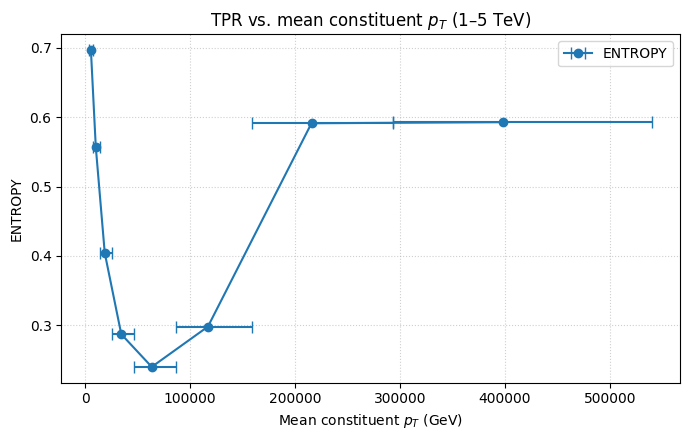

In [ ]:
# 1. Bin only jets with 1 TeV ≤ mean_pt ≤ 5 TeV
metric = "entropy"
binned = binned_metric_by_logpt(
    df,
    pt_col="mean_pt",
    metric=metric,
    bins=8,                     # 8 log-bins inside the range
    thr=0.5,
    #pt_range=(1000, 5000)       # <-- YOUR FIXED RANGE
)

print(binned[[ "pt_low", "pt_high", "pt_mid", "n_jets", metric]])

# 2. Plot (linear pT axis)
fig = plot_binned_metric(
    binned,
    metric=metric,
    title="TPR vs. mean constituent $p_T$ (1–5 TeV)"
)
plt.tight_layout()
plt.show()

# old 2

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import (
    precision_score,
    recall_score,
    accuracy_score,
    confusion_matrix,
    roc_auc_score,
    roc_curve
)

# Assume these exist in your project:
# from your_module import BNN, TabularDataset, get_logger


# ==========================================================
# Monte Carlo Inference (Binary)
# ==========================================================
def mc_inference(model, x, n_samples=50):
    """
    Perform MC-dropout inference for binary classification.
    Returns:
        probs: [S, B]
        mean_p: [B]
        entropy: [B]
        mutual_info: [B]
    """
    model.train()
    for m in model.modules():
        if isinstance(m, nn.BatchNorm1d):
            m.eval()

    with torch.no_grad():
        preds = torch.stack([model(x) for _ in range(n_samples)])  # [S, B]
        probs = torch.sigmoid(preds)

    # Predictive mean over samples
    mean_p = probs.mean(0)  # [B]

    # Predictive entropy H[p(y|x, D)]
    mean_probs = torch.stack([1 - mean_p, mean_p], dim=-1)  # [B, 2]
    entropy = -(mean_probs * mean_probs.clamp(min=1e-8).log()).sum(-1)

    # Expected entropy E_p(w)[H[p(y|x, w)]]
    probs_stacked = torch.stack([1 - probs, probs], dim=-1)  # [S, B, 2]
    exp_entropy = -(probs_stacked * probs_stacked.clamp(min=1e-8).log()).sum(-1).mean(0)

    # Mutual information = total uncertainty - expected aleatoric uncertainty
    mutual_info = entropy - exp_entropy

    return probs, mean_p, entropy, mutual_info


# ==========================================================
# Model Loader
# ==========================================================
def load_model(path_to_checkpoint, input_dim, device):
    model = BNN(input_dim)
    checkpoint = torch.load(path_to_checkpoint, map_location=device)
    state = checkpoint.get("model_state", checkpoint)
    model.load_state_dict(state)
    model.to(device)
    model.eval()
    return model


# ==========================================================
# Bayesian Robustness Analysis (Binary only)
# ==========================================================
def analyze_bnn_robustness(
    path_to_checkpoint,
    path_to_dataset,
    n_samples=50,
    batch_size=256,
    target_signal_eff=0.8,
    max_jets=100_000,
):
    device = "cpu"
    logger = get_logger("bnn_robustness")

    dataset = TabularDataset(path_to_dataset, max_jets=max_jets)
    x0, y0, *_ = dataset[0]
    input_dim = x0.numel()

    model = load_model(path_to_checkpoint, input_dim, device)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    mean_ps, entropies, mis, targets = [], [], [], []

    logger.info("Running BNN inference (binary)...")

    for idx, batch in enumerate(loader):
        x, y = batch[0].to(device).view(batch[0].size(0), -1), batch[1]
        _, mean_p, entropy, mutual_info = mc_inference(model, x, n_samples)
        mean_ps.append(mean_p.cpu())
        entropies.append(entropy.cpu())
        mis.append(mutual_info.cpu())
        targets.append(y.cpu())

    mean_ps = torch.cat(mean_ps).numpy().flatten()
    entropies = torch.cat(entropies).numpy().flatten()
    mis = torch.cat(mis).numpy().flatten()
    targets = torch.cat(targets).numpy()

    # Handle one-hot targets if necessary
    if targets.ndim > 1:
        targets = np.argmax(targets, axis=1)

    # ======================================================
    # Determine threshold for given signal efficiency
    # ======================================================
    signal_mask = targets == 1
    signal_scores = np.ravel(mean_ps[signal_mask])
    sorted_scores = np.sort(signal_scores)[::-1]
    cutoff_index = int(len(sorted_scores) * target_signal_eff)
    cutoff_index = max(1, min(cutoff_index, len(sorted_scores) - 1))
    threshold = float(np.ravel(sorted_scores)[cutoff_index])
    preds = (mean_ps > threshold).astype(int)

    print(f"\nUsing threshold = {threshold:.4f} for target signal efficiency = {target_signal_eff:.2f}")

    # ======================================================
    # Metrics
    # ======================================================
    acc = accuracy_score(targets, preds)
    prec = precision_score(targets, preds)
    rec = recall_score(targets, preds)
    tpr = rec
    tn, fp, fn, tp = confusion_matrix(targets, preds).ravel()
    fpr = fp / (fp + tn)
    auc = roc_auc_score(targets, mean_ps)

    print("\n=== MODEL PERFORMANCE ===")
    print(f"AUC:       {auc:.4f}")
    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"TPR:       {tpr:.4f}")
    print(f"FPR:       {fpr:.4f}")

    # ======================================================
    # Uncertainty Statistics
    # ======================================================
    print("\n=== UNCERTAINTY STATISTICS ===")
    print(f"Mean entropy:        {entropies.mean():.4f}")
    print(f"Mean mutual info:    {mis.mean():.4f}")
    print(f"Entropy (correct):   {entropies[preds == targets].mean():.4f}")
    print(f"Entropy (incorrect): {entropies[preds != targets].mean():.4f}")

    df = pd.DataFrame({
        "target": targets,
        "pred": preds,
        "conf": mean_ps,
        "entropy": entropies,
        "mutual_info": mis,
        "correct": (preds == targets).astype(int),
    })

    # ======================================================
    # PLOTS
    # ======================================================

    # ROC
    fpr_curve, tpr_curve, _ = roc_curve(targets, mean_ps)
    plt.figure(figsize=(6, 6))
    plt.plot(fpr_curve, tpr_curve, label=f"AUC = {auc:.3f}")
    plt.plot([0, 1], [0, 1], "k--", lw=1)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

    # Entropy plots

    # Entropy by Class
    plt.figure(figsize=(12, 5))

    # Background
    plt.subplot(1, 2, 1)
    mask_bkg = df["target"] == 0
    plt.hist(df.loc[mask_bkg & (df.correct == 1), "entropy"],
             bins=40, color="green", alpha=0.6, label="Correct", edgecolor="black")
    plt.hist(df.loc[mask_bkg & (df.correct == 0), "entropy"],
             bins=40, color="red", alpha=0.6, label="Incorrect", edgecolor="black")
    plt.title("Entropy — Background Jets")
    plt.xlabel("Entropy")
    plt.ylabel("Count")
    plt.legend()
    plt.grid(alpha=0.3)

    # Signal
    plt.subplot(1, 2, 2)
    mask_sig = df["target"] == 1
    plt.hist(df.loc[mask_sig & (df.correct == 1), "entropy"],
             bins=40, color="green", alpha=0.6, label="Correct", edgecolor="black")
    plt.hist(df.loc[mask_sig & (df.correct == 0), "entropy"],
             bins=40, color="red", alpha=0.6, label="Incorrect", edgecolor="black")
    plt.title("Entropy — Signal Jets")
    plt.xlabel("Entropy")
    plt.ylabel("Count")
    plt.legend()
    plt.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Confidence by Class
    plt.figure(figsize=(12, 5))

    # Background
    plt.subplot(1, 2, 1)
    plt.hist(df.loc[mask_bkg & (df.correct == 1), "conf"],
             bins=40, color="green", alpha=0.6, label="Correct", edgecolor="black")
    plt.hist(df.loc[mask_bkg & (df.correct == 0), "conf"],
             bins=40, color="red", alpha=0.6, label="Incorrect", edgecolor="black")
    plt.title("Confidence — Background Jets")
    plt.xlabel("Predicted P(signal)")
    plt.ylabel("Count")
    plt.legend()
    plt.grid(alpha=0.3)

    # Signal
    plt.subplot(1, 2, 2)
    plt.hist(df.loc[mask_sig & (df.correct == 1), "conf"],
             bins=40, color="green", alpha=0.6, label="Correct", edgecolor="black")
    plt.hist(df.loc[mask_sig & (df.correct == 0), "conf"],
             bins=40, color="red", alpha=0.6, label="Incorrect", edgecolor="black")
    plt.title("Confidence — Signal Jets")
    plt.xlabel("Predicted P(signal)")
    plt.ylabel("Count")
    plt.legend()
    plt.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

    logger.info("BNN robustness analysis complete.")
    return df


2025-10-22 10:28:01 - bnn_robustness - INFO - Running BNN inference (binary)...
2025-10-22 10:28:01 - bnn_robustness - INFO - Running BNN inference (binary)...

Using threshold = 0.9701 for target signal efficiency = 0.50

=== MODEL PERFORMANCE ===
AUC:       0.7722
Accuracy:  0.6797
Precision: 0.7652
Recall:    0.5000
TPR:       0.5000
FPR:       0.1475

=== UNCERTAINTY STATISTICS ===
Mean entropy:        0.3156
Mean mutual info:    0.0175
Entropy (correct):   0.3202
Entropy (incorrect): 0.3059

2025-10-24 23:18:11 - bnn_robustness - INFO - Running BNN inference (binary)...
2025-10-24 23:18:11 - bnn_robustness - INFO - Running BNN inference (binary)...

Using threshold = 0.4661 for target signal efficiency = 0.80

=== MODEL PERFORMANCE ===
AUC:       0.8683
Accuracy:  0.7858
Precision: 0.7775
Recall:    0.8000
TPR:       0.8000
FPR:       0.2283

=== UNCERTAINTY STATISTICS ===
Mean entropy:        0.4732
Mean mutual info:    0.0154
Entropy (correct):   0.4384
Entropy (incorrect): 0.6009

2025-10-24 23:18:11 - bnn_robustness - INFO - Running BNN inference (binary)...
2025-10-24 23:18:11 - bnn_robustness - INFO - Running BNN inference (binary)...



Using threshold = 0.4661 for target signal efficiency = 0.80

=== MODEL PERFORMANCE ===
AUC:       0.8683
Accuracy:  0.7858
Precision: 0.7775
Recall:    0.8000
TPR:       0.8000
FPR:       0.2283

=== UNCERTAINTY STATISTICS ===
Mean entropy:        0.4732
Mean mutual info:    0.0154
Entropy (correct):   0.4384
Entropy (incorrect): 0.6009


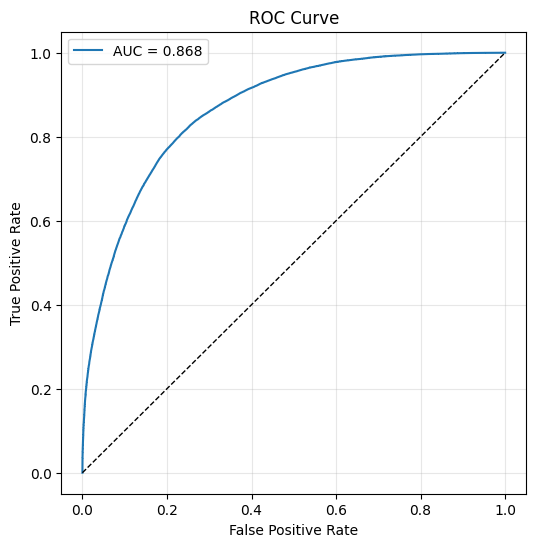

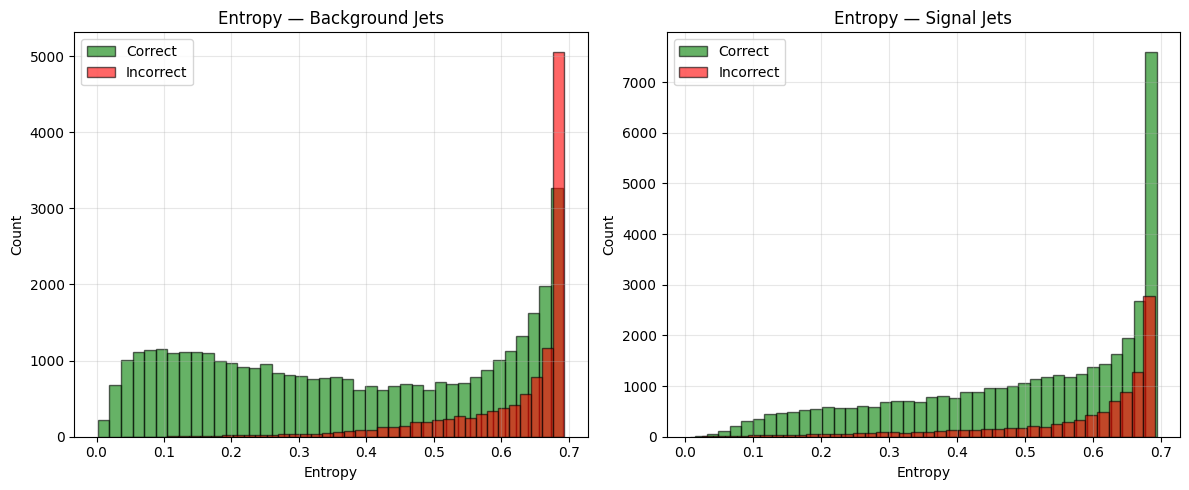

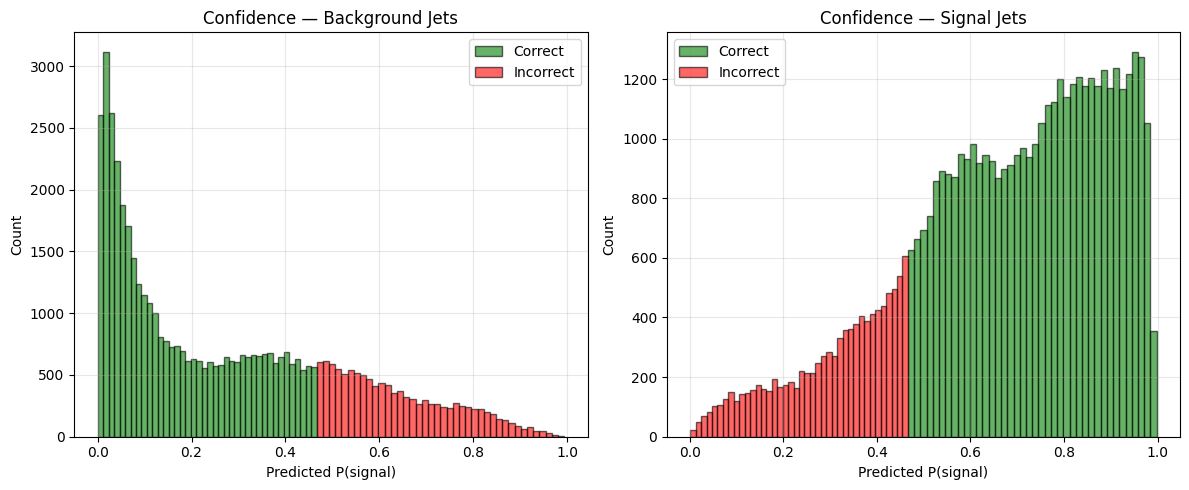

2025-10-24 23:19:14 - bnn_robustness - INFO - BNN robustness analysis complete.
2025-10-24 23:19:14 - bnn_robustness - INFO - BNN robustness analysis complete.


In [ ]:
df_results = analyze_bnn_robustness(
        path_to_checkpoint="../checkpoints/bnn/best_model.pt",
        path_to_dataset="../data/test-preprocessed.h5",
        n_samples=20,
        target_signal_eff=0.8,
        max_jets=100_000, # NOTE: Set this to 10_000 if it gets to slow
    )

2025-10-24 23:25:36 - bnn_robustness - INFO - Running BNN inference (binary)...



Using threshold = 0.8100 for target signal efficiency = 0.80

=== MODEL PERFORMANCE ===
AUC:       0.7690
Accuracy:  0.6929
Precision: 0.6585
Recall:    0.8000
TPR:       0.8000
FPR:       0.4139

=== UNCERTAINTY STATISTICS ===
Mean entropy:        0.3339
Mean mutual info:    0.0285
Entropy (correct):   0.3230
Entropy (incorrect): 0.3587


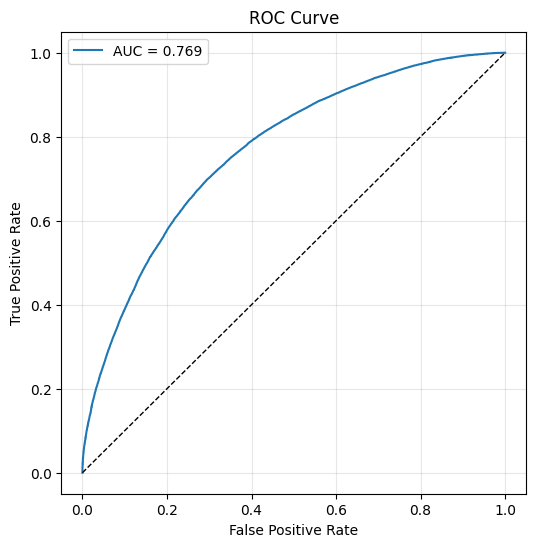

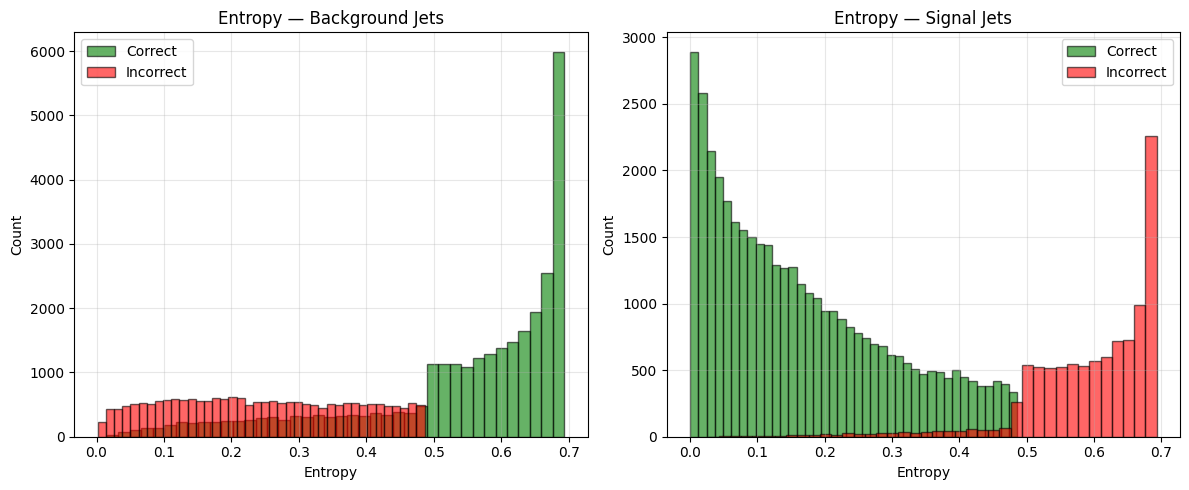

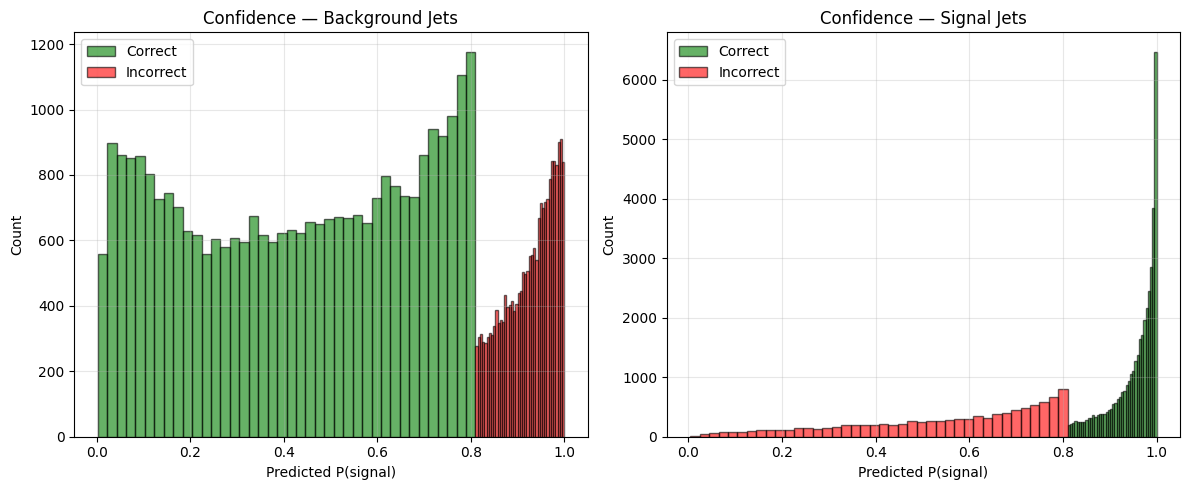

2025-10-24 23:26:20 - bnn_robustness - INFO - BNN robustness analysis complete.


In [ ]:
df_results = analyze_bnn_robustness(
        path_to_checkpoint="../checkpoints/bnn/best_model.pt",
        path_to_dataset="../data/test-preprocessed.h5",
        n_samples=20,
        target_signal_eff=0.8,
        max_jets=100_000, # NOTE: Set this to 10_000 if it gets to slow
    )